# Data Preparation
This notebook was created to prepare the training and test datasets for this product.

## Libraries and imports

In [69]:
import sys
sys.path.append('..')
from scripts.utils import initialize_bucket, plot_importance

from datetime import date

import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import KFold, cross_val_score,cross_validate
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, explained_variance_score,mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, Normalizer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import shap

import pickle
import json


## Setup

## Methods and functions

### Feature engineering

In [70]:
def data_plausibilization(data, label, limit1, limit2):
    """Filter Data Based on Label Value

    Filters the input data by removing rows where the specified label's value exceeds a given limit.

    Args:
        data (pandas.DataFrame): The input DataFrame containing the data to be filtered.
        label (str): The name of the column representing the label to be checked.
        limit (float): The value limit. Rows with label values greater than this limit will be removed.

    Returns:
        pandas.DataFrame: A filtered DataFrame containing rows where the label's value is below the limit.

    Example:
        >>> import pandas as pd
        >>> data = pd.DataFrame({'feature': [10, 15, 5, 8]})
        >>> label = 'feature'
        >>> limit = 10
        >>> filtered_data = data_plausibilization(data, label, limit)
        >>> print(filtered_data)
           feature
        2         5
        3         8
    """
    data = data[data[label]<limit1]

    data[data[label]>limit2] = limit2

    return data


In [71]:
def transform_dataframe(df, setor_encoding):
    """
    Apply various transformations to the given DataFrame.

    This function applies a series of calculations and replacements to columns
    in the provided DataFrame to derive new values based on existing columns.

    Args:
        df (pandas.DataFrame): The input DataFrame containing necessary columns.
        setor_encoding (dict): A dictionary mapping sector names to encoded values.

    Returns:
        None. The input DataFrame is modified in place with added/replaced columns.

    Example:
        >>> sector_encoding = {'Tech': 1, 'Finance': 2, 'Healthcare': 3}
        >>> transform_dataframe(input_df, sector_encoding)
        # The input_df DataFrame will be modified with new/replaced columns.
    """
    # Replace values in 'dy_mean_std' column
    df['dy_mean_std'][(df['dy_mean_std'] <= 0.005) & (df['dy_median_min'] <= 0.005)] = df['dy_mean_std'].max()

    # Encode sectors using the provided setor_encoding dictionary
    df['encoded_sectors'] = df['Setor'].replace(setor_encoding)

    # Calculate power_valuation column
    df['power_valuation'] = df['roe_mean_last'] * df['roic_mean_last'] * df['roe_mean_mean'] * df['roe_mean_mean']

    # Calculate power_price column using multiple columns
    df['power_price'] = (df['pl_mean_last'] * df['pa_mean_last']) / (df['pl_mean_ref_mean'] * df['pa_mean_ref_mean'])

    # Calculate power_margin column
    df['power_margin'] = (df['mrgliq_mean_last'] / 1_000_000) * (df['mrgebit_mean_last'] / 1_000_000)

    # Calculate power_buy_flag column
    df['power_buy_flag'] = df['pl_mean_last'] * df['dy_median_last'] * df['dy_median_min']

    # Calculate power_stabil column
    df['power_stabil'] = df['dy_median_min'] / df['dy_mean_std']

    # Calculate power_stabil_delta column
    df['power_stabil_delta'] = (df['dy_median_max'] - df['dy_median_min']) / df['dy_mean_std']

    # Calculate power_min column
    df['power_min'] = df['dy_median_min'] * df['dy_median_ref_min']

    return df

In [72]:
def create_trends(data, roots):
    """
    Calculate trends based on specified roots and add them to the data.

    This function calculates trends for each specified root by dividing the last value
    by the mean value and converting the result to a percentage change. The calculated
    trends are then added as new columns to the provided data.

    Args:
        data (pandas.DataFrame): The input DataFrame containing necessary columns.
        roots (list): A list of root names for which trends should be calculated.

    Returns:
        pandas.DataFrame: A modified DataFrame with added trend columns.

    Example:
        >>> roots_to_calculate = ['roe', 'roic', 'pl']
        >>> modified_df = create_trends(input_df, roots_to_calculate)
        # The modified_df DataFrame will contain additional columns for trends.
    """
    data_out = data.copy()
    for root in roots:
        try:
            trend_column_name = root + '_trend'
            trend_values = ((np.divide(data_out[root + '_last'], data_out[root + '_mean']) - 1) * 100)
            data_out[trend_column_name] = trend_values
        except:
            continue
    return data_out



In [73]:
def transform_dummy(data, features):
    """
    Transform categorical values into numerical values using one-hot encoding.
    
    Parameters:
        data (DataFrame): The DataFrame containing the categorical features to be transformed.
        features (list): List of categorical features to be transformed.
        
    Returns:
        DataFrame: The transformed DataFrame with numerical values for categorical features.
    """
    for feature in features:
        # Generate one-hot encoded columns and append to the DataFrame
        one_hot_encoded = pd.get_dummies(data[feature])
        new_columns = [(str(feature) + '_' + str(col)) for col in one_hot_encoded.columns]
        data[new_columns] = one_hot_encoded
        
        # Drop the original categorical feature from the DataFrame
        data.drop(feature, axis=1, inplace=True)
        
    return data

In [74]:
def column_name_cleaner(col):
    """
    Clean column names by replacing non-UTF-8 characters with a replacement character.

    Parameters:
        col (str): The column name to be cleaned.

    Returns:
        str: The cleaned column name.
    """
    return col.encode('utf-8', 'replace').decode('utf-8')

In [75]:
def create_year_month_column(data: pd.DataFrame, year_column: str, month_column: str) -> pd.DataFrame:
    """
    Create a new column 'year_month' in the DataFrame by concatenating values from two columns.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the columns 'year_last' and 'month_last'.
        year_column (str): Name of the column containing the year values.
        month_column (str): Name of the column containing the month values.

    Returns:
        pd.DataFrame: The DataFrame with a new 'year_month' column.
    """
    # Ensure that the specified columns exist in the DataFrame
    if year_column not in data.columns or month_column not in data.columns:
        raise ValueError(f"Columns '{year_column}' and '{month_column}' not found in the DataFrame.")
    
    # Create the 'year_month' column by concatenating the values from 'year_last' and 'month_last' columns
    data['year_month'] = data[year_column].astype(str) + data[month_column].astype(str)
    
    return data

## Load Data

In [76]:
pd.set_option("display.max_columns", 400)

credentials_path = '../datascience-capstone-project-05b1642f45c3.json'

In [77]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path = "gs://storage-barsianize/03_refined/df_windowed_full.parquet"
base_dataset =  pd.read_parquet(path)

df = base_dataset.copy()

In [78]:
df

,cotacao_max_max,cotacao_min_min,cotacao_mean_mean,cotacao_mean_std,pl_max_max,pl_min_min,pl_mean_mean,pl_mean_std,pvp_max_max,pvp_min_min,pvp_mean_mean,pvp_mean_std,psr_max_max,psr_min_min,psr_mean_mean,psr_mean_std,dy_max_max,dy_min_min,dy_median_max,dy_median_min,dy_mean_mean,dy_mean_std,pa_max_max,pa_min_min,pa_mean_mean,pa_mean_std,pcg_max_max,pcg_min_min,pcg_mean_mean,pcg_mean_std,pebit_max_max,pebit_min_min,pebit_mean_mean,pebit_mean_std,pacl_max_max,pacl_min_min,pacl_mean_mean,pacl_mean_std,mrgebit_max_max,mrgebit_min_min,mrgebit_mean_mean,mrgebit_mean_std,mrgliq_max_max,mrgliq_min_min,mrgliq_mean_mean,mrgliq_mean_std,roic_max_max,roic_min_min,roic_mean_mean,roic_mean_std,roe_max_max,roe_min_min,roe_mean_mean,roe_mean_std,liqc_max_max,liqc_min_min,liqc_mean_mean,liqc_mean_std,liq2m_max_max,liq2m_min_min,liq2m_mean_mean,liq2m_mean_std,patrliq_max_max,patrliq_min_min,patrliq_mean_mean,patrliq_mean_std,divbpatr_max_max,divbpatr_min_min,divbpatr_mean_mean,divbpatr_mean_std,c5y_max_max,c5y_min_min,c5y_mean_mean,c5y_mean_std,indice_da_industria_min,indice_da_industria_max,indice_da_industria_mean,indice_da_industria_std,dolar_comercial_min,dolar_comercial_max,dolar_comercial_mean,dolar_comercial_std,euro_min,euro_max,euro_mean,euro_std,ibovespa_min,ibovespa_max,ibovespa_mean,ibovespa_std,pib_dolarizado_min,pib_dolarizado_max,pib_dolarizado_mean,pib_dolarizado_std,igpm_min,igpm_max,igpm_mean,igpm_std,ipca_min,ipca_max,ipca_mean,ipca_std,selic_min,selic_max,selic_mean,selic_std,cotacao_max_ref_max,cotacao_min_ref_min,cotacao_mean_ref_mean,cotacao_mean_ref_std,pl_max_ref_max,pl_min_ref_min,pl_mean_ref_mean,pl_mean_ref_std,pvp_max_ref_max,pvp_min_ref_min,pvp_mean_ref_mean,pvp_mean_ref_std,psr_max_ref_max,psr_min_ref_min,psr_mean_ref_mean,psr_mean_ref_std,dy_max_ref_max,dy_min_ref_min,dy_median_ref_max,dy_median_ref_min,dy_mean_ref_mean,dy_mean_ref_std,pa_max_ref_max,pa_min_ref_min,pa_mean_ref_mean,pa_mean_ref_std,pcg_max_ref_max,pcg_min_ref_min,pcg_mean_ref_mean,pcg_mean_ref_std,pebit_max_ref_max,pebit_min_ref_min,pebit_mean_ref_mean,pebit_mean_ref_std,pacl_max_ref_max,pacl_min_ref_min,pacl_mean_ref_mean,pacl_mean_ref_std,mrgebit_max_ref_max,mrgebit_min_ref_min,mrgebit_mean_ref_mean,mrgebit_mean_ref_std,mrgliq_max_ref_max,mrgliq_min_ref_min,mrgliq_mean_ref_mean,mrgliq_mean_ref_std,roic_max_ref_max,roic_min_ref_min,roic_mean_ref_mean,roic_mean_ref_std,roe_max_ref_max,roe_min_ref_min,roe_mean_ref_mean,roe_mean_ref_std,liqc_max_ref_max,liqc_min_ref_min,liqc_mean_ref_mean,liqc_mean_ref_std,liq2m_max_ref_max,liq2m_min_ref_min,liq2m_mean_ref_mean,liq2m_mean_ref_std,patrliq_max_ref_max,patrliq_min_ref_min,patrliq_mean_ref_mean,patrliq_mean_ref_std,divbpatr_max_ref_max,divbpatr_min_ref_min,divbpatr_mean_ref_mean,divbpatr_mean_ref_std,c5y_max_ref_max,c5y_min_ref_min,c5y_mean_ref_mean,c5y_mean_ref_std,Papel,Tipo,Empresa,Setor,Subsetor,Data_ult_cot,Lucro_Liquido_12m_category,Valor_de_mercado_category,Patrim_Liq_category,besst_1,besst_2,year_last,date_last_last,month_last,indice_da_industria_last,dolar_comercial_last,euro_last,ibovespa_last,pib_dolarizado_last,igpm_last,ipca_last,selic_last,cotacao_mean_last,c5y_mean_last,pl_mean_last,pvp_mean_last,psr_mean_last,dy_mean_last,dy_median_last,pa_mean_last,pcg_mean_last,pebit_mean_last,pacl_mean_last,mrgebit_mean_last,mrgliq_mean_last,roic_mean_last,roe_mean_last,liqc_mean_last,liq2m_mean_last,patrliq_mean_last,divbpatr_mean_last,dy_label,cotacao_spread,pl_spread,pvp_spread,psr_spread,dy_spread,dy_median_spread,pa_spread,pcg_spread,pebit_spread,pacl_spread,mrgebit_spread,mrgliq_spread,roic_spread,roe_spread,liqc_spread,liq2m_spread,patrliq_spread,divbpatr_spread,c5y_spread,indice_da_industria_spread,dolar_comercial_spread,euro_spread,ibovespa_spread,pib_dolarizado_spread,igpm_spread,ipca_spread,selic_spread,cotacao_ref_spread,pl_ref_spread,pvp_ref_spread,psr_ref_spread,dy_ref_spread,dy_median_ref_spread,pa_ref_spread,pcg_ref_spread,pebit_ref_spread,pacl_ref_spread,mrgebit_ref_spread,mrgliq_ref_

In [79]:
create_year_month_column(df, 'year_last', 'month_last')['year_month'].max()

'2022.04.0'

In [80]:
df = create_year_month_column(df, 'year_last', 'month_last')

In [81]:
df['year_month'][df['Papel']=='BBAS3']

5394     2009.06.0
5395     2009.07.0
5396     2009.08.0
5397     2009.09.0
5398    2009.010.0
           ...    
5544    2021.012.0
5545     2022.01.0
5546     2022.02.0
5547     2022.03.0
5548     2022.04.0
Name: year_month, Length: 155, dtype: object

## Feature Selection

In [82]:
features = [
                'Empresa', 'Papel',
                'year_last', 'month_last',
                'besst_1', 'besst_2',
                'Setor','Tipo',
                'Lucro_Liquido_12m_category',
                # 'Valor_de_mercado_category',
                # 'Patrim_Liq_category',
                'dy_label',
                'dy_median_last', 'dy_median_max','dy_median_min','dy_spread','dy_mean_std','dy_mean_last', 'dy_median_ref_min',#add dy relativo
                'euro_last','euro_mean', #add euro relativo
                'c5y_mean_last','c5y_mean_mean', #add c5y relativo
                'cotacao_max_ref_max','cotacao_mean_ref_mean','cotacao_mean_ref_std', 'cotacao_mean_last', 'cotacao_mean_mean',#add cotacao relativo
                'divbpatr_max_ref_max','divbpatr_mean_last','divbpatr_mean_mean', #add divbpatr relativo
                'dolar_comercial_last','dolar_comercial_mean', #add euro relativo
                'ibovespa_spread','ibovespa_spread_relevance','ibovespa_last','ibovespa_mean',#add ibovespa relativo
                'pib_dolarizado_last','pib_dolarizado_mean', #add pib_dolarizado relativo
                'igpm_last','igpm_mean',#add igpm relativo
                'ipca_last','ipca_mean',#add ipca relativo
                'selic_last','selic_mean',#add igpm relativo
                'liq2m_mean_ref_mean','liq2m_mean_last','liq2m_mean_mean', #add liq2m relativo
                'liqc_mean_ref_mean','liqc_mean_last','liqc_mean_mean', #add liqc relativo
                'mrgebit_mean_ref_mean','mrgebit_mean_last','mrgebit_mean_mean', #add mrgebit relativo
                'mrgliq_mean_ref_mean','mrgliq_mean_last','mrgliq_mean_mean', #add mrgliq relativo
                'pa_mean_ref_mean','pa_mean_last', 'pa_mean_mean',#add pa relativo
                'pl_mean_ref_mean','pl_mean_last', 'pl_mean_mean',#add pa relativo
                'pcg_mean_ref_mean','pcg_mean_last', 'pcg_mean_mean',#add pcg relativo
                'pebit_mean_ref_mean','pebit_mean_last', 'pebit_mean_mean',#add pebit relativo
                'pacl_mean_ref_mean','pacl_mean_last', 'pacl_mean_mean',#add pacl relativo
                'psr_mean_ref_mean','psr_mean_last', 'psr_mean_mean',#add psr relativo
                'pvp_mean_ref_mean','pvp_mean_last', 'pvp_mean_mean',#add pvp relativo
                'roe_mean_ref_mean','roe_mean_last', 'roe_mean_mean',#add roe relativo
                'roic_mean_ref_mean','roic_mean_last', 'roic_mean_mean',#add roic relativo
                'patrliq_mean_ref_mean','patrliq_mean_last','patrliq_mean_mean', #add patrliq relativo
            ]

roots = [
            'euro',
            'dy_mean',
            'c5y_mean',
            'cotacao_mean',
            'divbpatr_mean',
            'dolar_comercial',
            'ibovespa',
            'pib_dolarizado',
            'preco_do_petroleo',
            'igpm',
            'ipca',
            'selic',
            'liq2m',
            'liqc',
            'mrgebit',
            'mrgliq',
            'pa_mean',
            'pl_mean',
            'pcg_mean',
            'pebit_mean',
            'pacl_mean',
            'psr_mean',
            'pvp_mean',
            'roe_mean',
            'roic_mean_last',
            'patrliq_mean'
        ]

setor_encoding = {
    'Computadores e Equipamentos':1,
    'Tecidos, Vestuário e Calçados':2,
    'Máquinas e Equipamentos':3,
    'Equipamentos':4,
    'Automóveis e Motocicletas':5,
    'Bebidas':6,
    'Alimentos Processados':7,
    'Produtos de Uso Pessoal e de Limpeza':8,
    'Utilidades Domésticas':9,
    'Embalagens':10,
    'Materiais Diversos':11,
    'Medicamentos e Outros Produtos':12,
    'Serv.Méd.Hospit. Análises e Diagnósticos':13,
    'Hoteis e Restaurantes':14,
    'Viagens e Lazer':15,
    'Transporte':16,
    'Material de Transporte':17,
    'Serviços Diversos':18,
    'Programas e Serviços':19,
    'Comércio e Distribuição':20,
    'Comércio':21,
    'Telecomunicações':22,
    'Mídia':23,
    'Holdings Diversificadas':24,
    'Serviços Financeiros Diversos':25,
    'Intermediários Financeiros':26,
    'Previdência e Seguros':27,
    'Exploração de Imóveis':28,
    'Químicos':29,
    'Construção e Engenharia':30,
    'Construção Civil':31,
    'Siderurgia e Metalurgia':32,
    'Energia Elétrica':33,
    'Água e Saneamento':34,
    'Gás':35,
    'Petróleo, Gás e Biocombustíveis':36,
    'Mineração':37,
    'Madeira e Papel':38,
    'Agropecuária':39,
    'Diversos':40,
    'Outros':41,
}

In [83]:
df = df[features]

df = data_plausibilization(df, 'dy_label', 10, 1)

df = transform_dataframe(df, setor_encoding)

df.columns = [column_name_cleaner(col) for col in df.columns]

df = create_year_month_column(df, 'year_last', 'month_last')

df = transform_dummy(df,['Tipo'])

# Assuming 'df' is your DataFrame and 'roots' is a list of root names
df = create_trends(df, roots)
# creating tolerance boundaries to avoid infinite values
df['power_price'] = df['power_price'].apply(lambda x:10 if x>= 10 else x)
df['power_price'] = df['power_price'].apply(lambda x: -10 if x<= -10 else x)
df['power_stabil'] = df['power_stabil'].apply(lambda x:10 if x>= 10 else x)
df['power_stabil'] = df['power_stabil'].apply(lambda x: -10 if x<= -10 else x)
df['c5y_mean_trend'] = df['c5y_mean_trend'].apply(lambda x: 100 if x>= 100 else x)
df['c5y_mean_trend'] = df['c5y_mean_trend'].apply(lambda x: -100 if x<= -100 else x)
df['divbpatr_mean_trend'] = df['divbpatr_mean_trend'].apply(lambda x:10 if x>= 10 else x)
df['divbpatr_mean_trend'] = df['divbpatr_mean_trend'].apply(lambda x: -10 if x<= -10 else x)
df['pa_mean_trend'] = df['pa_mean_trend'].apply(lambda x: 100 if x>= 100 else x)
df['pl_mean_trend'] = df['pl_mean_trend'].apply(lambda x: 100 if x>= 100 else x)
df['pl_mean_trend'] = df['pl_mean_trend'].apply(lambda x: 100 if x<= -100 else x)
df['pcg_mean_trend'] = df['pcg_mean_trend'].apply(lambda x: 100 if x>= 100 else x)
df['pcg_mean_trend'] = df['pcg_mean_trend'].apply(lambda x: 100 if x<= -100 else x)
df['pebit_mean_trend'] = df['pebit_mean_trend'].apply(lambda x: 100 if x>= 100 else x)
df['pebit_mean_trend'] = df['pebit_mean_trend'].apply(lambda x: -100 if x<= -100 else x)
df['pacl_mean_trend'] = df['pacl_mean_trend'].apply(lambda x: 100 if x>= 100 else x)
df['pacl_mean_trend'] = df['pacl_mean_trend'].apply(lambda x: -100 if x<= -100 else x)
df['psr_mean_trend'] = df['psr_mean_trend'].apply(lambda x: 100 if x>= 100 else x)
df['psr_mean_trend'] = df['psr_mean_trend'].apply(lambda x: -100 if x<= -100 else x)
df['pvp_mean_trend'] = df['pvp_mean_trend'].apply(lambda x: 100 if x>= 100 else x)
df['pvp_mean_trend'] = df['pvp_mean_trend'].apply(lambda x: -100 if x<= -100 else x)
df['roe_mean_trend'] = df['roe_mean_trend'].apply(lambda x: 100 if x>= 100 else x)
df['roe_mean_trend'] = df['roe_mean_trend'].apply(lambda x: -100 if x<= -100 else x)
df['patrliq_mean_trend'] = df['patrliq_mean_trend'].apply(lambda x: 100 if x>= 100 else x)
df['patrliq_mean_trend'] = df['patrliq_mean_trend'].apply(lambda x: -100 if x<= -100 else x)

object_cols = df.columns[df.dtypes == 'object'] 
print(object_cols)
bool_cols = df.columns[df.dtypes == 'bool'] 
print(bool_cols)

# dropping columns with maximum values larger than 1 trillion dollars
to_drop = df.columns[df.dtypes=='float64'][(df[df.columns[df.dtypes=='float64']].max()>1_000_000_000_000)]
print(df[to_drop].max())
# df = df.drop(to_drop, axis=1)

# transforming bool_cols to float
df[bool_cols] = df[bool_cols].astype('float64')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a D

Index(['Empresa', 'Papel', 'besst_1', 'besst_2', 'Setor', 'year_month'], dtype='object')
Index([], dtype='object')
liq2m_mean_ref_mean      8.697993e+38
patrliq_mean_ref_mean    1.410626e+12
dtype: float64


In [84]:
# checking NaN values and inputing median
df.isna().mean().sort_values(ascending=False)[:20]

divbpatr_mean_trend    0.134335
psr_mean_trend         0.109424
pacl_mean_trend        0.104405
pcg_mean_trend         0.104405
pebit_mean_trend       0.100716
pa_mean_trend          0.095110
c5y_mean_trend         0.016112
roe_mean_trend         0.005605
pl_mean_trend          0.005605
power_price            0.005605
roe_mean_ref_mean      0.000000
pvp_mean_ref_mean      0.000000
pvp_mean_last          0.000000
pvp_mean_mean          0.000000
roic_mean_ref_mean     0.000000
roe_mean_last          0.000000
roe_mean_mean          0.000000
psr_mean_last          0.000000
roic_mean_last         0.000000
psr_mean_mean          0.000000
dtype: float64

In [85]:
# inpute 0 for missing values
df.fillna(0, inplace=True)

<AxesSubplot:>

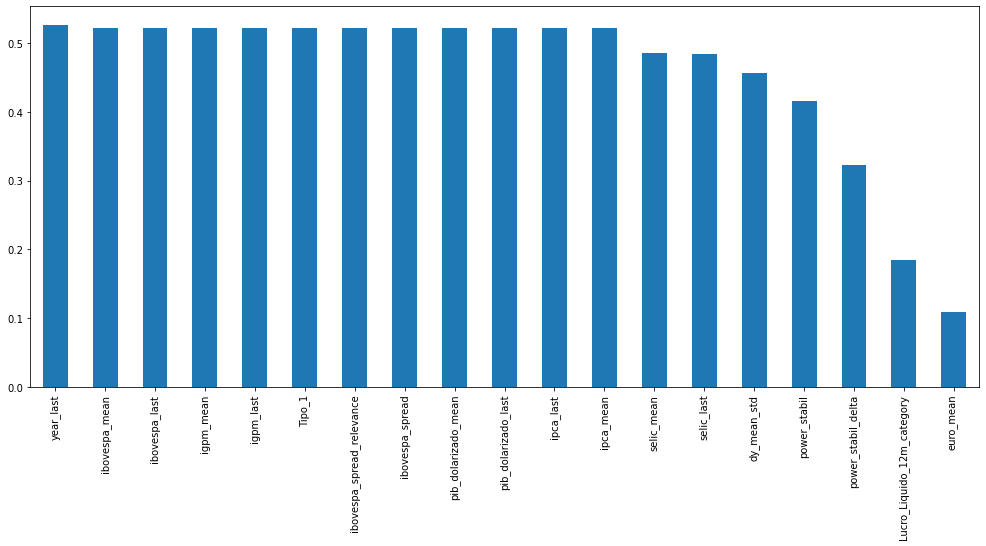

In [86]:
cor = df.corr()['dy_label']

training_cols = np.abs(cor).sort_values(ascending=False)[0:150].index

plt.figure(figsize=(17,7))
np.abs(cor).sort_values(ascending=False)[1:20].plot(kind='bar')

In [87]:
df_to_train = df[['Empresa', 'Papel', 'year_month'] + list(training_cols)].copy()
df_to_train.drop('month_last', axis=1, inplace=True)

df_to_pred  = df_to_train[df_to_train['year_month']=='2022.04.0'].copy()
df = df_to_train[df_to_train['year_month']!='2022.04.0']

In [88]:
df['year_month']

24        2009.06.0
25        2009.07.0
26        2009.08.0
27        2009.09.0
28       2009.010.0
            ...    
91379     2022.03.0
91405     2022.03.0
91431     2022.03.0
91457     2022.03.0
91483     2022.03.0
Name: year_month, Length: 76108, dtype: object

In [89]:
df_to_pred['year_month'].unique()

array(['2022.04.0'], dtype=object)

In [90]:
df['year_month'][df['Papel']=='BBAS3']

5394     2009.06.0
5395     2009.07.0
5396     2009.08.0
5397     2009.09.0
5398    2009.010.0
           ...    
5543    2021.011.0
5544    2021.012.0
5545     2022.01.0
5546     2022.02.0
5547     2022.03.0
Name: year_month, Length: 154, dtype: object

In [91]:
df['year_month'].sort_values(ascending=False)

91483    2022.03.0
87404    2022.03.0
5726     2022.03.0
714      2022.03.0
36427    2022.03.0
           ...    
37496       1.01.0
37495       1.01.0
37494       1.01.0
37493       1.01.0
30793       1.01.0
Name: year_month, Length: 76108, dtype: object

## Store Data

In [92]:
client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path_local = '../data/04_datasets/'
filename = 'df_base_dataset.parquet'
blob_name = '05_datasets/'

# save the DataFrame as a parquet file
df.astype('str').to_parquet(path_local + filename)

# upload the parquet file to Google Cloud Storage
blob = bucket.blob(blob_name + filename)
blob._chunk_size = 8388608
blob.upload_from_filename(path_local + filename, num_retries=10, )



client, bucket = initialize_bucket(credentials_path,'storage-barsianize')

path_local = '../data/04_datasets/'
filename = 'df_to_pred.parquet'
blob_name = '05_datasets/'

# save the DataFrame as a parquet file
df_to_pred.astype('str').to_parquet(path_local + filename)

# upload the parquet file to Google Cloud Storage
blob = bucket.blob(blob_name + filename)
blob._chunk_size = 8388608
blob.upload_from_filename(path_local + filename, num_retries=10, )